In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
#from alternating import optimize
from itertools import count
from scipy import sparse
from sklearn import linear_model
import time

In [2]:
datasetPath = '../../train_triplets.txt'
n =300000
b = 10
ignoreLessThan = 5
num_test = 200

# k is the num of freedom of Q's cols and P's rows
k = 30

alpha = 0.5

%matplotlib inline

In [3]:
# read first n triplets from the dataset
def readTriplets(datasetPath, n):
    row = []
    col = []
    data = []

    user_to_row = {}
    song_to_col = {}
    user_count = count()
    song_count = count()
    limitingCounter = 0
    with open(datasetPath) as f:
        for triplet in f:
            if limitingCounter ==n:
                break
            limitingCounter+=1

            uid, sid, play_count =triplet.split('\t')
            #print (uid, sid, play_count)
            if not uid in user_to_row:
                user_to_row[uid] = next(user_count)
            row.append(user_to_row[uid])
            if not sid in song_to_col:
                song_to_col[sid] = next(song_count)
            col.append(song_to_col[sid])        
            data.append(int(play_count))
    return row, col, data

$Preprocess 1:$

assign compress all entries in M into [i,i+1]

In [4]:
def resetData(data):
    data = np.floor(np.log(data)/np.log(2)+1)
    data[data>b]=b
    return data

$Preprocess 2:$

Remove invalid songs and users

In [5]:
# construct the M
# input: raw row,c col, data, and ignoreLessThan
# return csr sparse pruned M
def constructM(row,col,data,ignoreLessThan):
    M = sparse.csr_matrix((data, (row, col)))
    size = M.shape
    count = 0
    while(True):
        count += 1
        mask = M!=0
        dr = mask.sum(axis=1)
        M = M[np.where(dr>ignoreLessThan)[0],:]
        mask = M!=0
        dc = mask.sum(axis=0)
        M = M[:,np.where(dc>ignoreLessThan)[1]]
        if size == M.shape:
            break
        size = M.shape    
    return M

$Preprocess3 :$

Draw test data

In [6]:
#divide M into test,validation and train datasets
# return test: first col of rows second col of cols and third col of data
#        validation: ...
#        train: same, train_M: csr sparse of trian M 
def divideM(M,num_test=200,num_validation=1000):
    # find out nonzeros of pruned M, and store the rows, cols, data in non0M
    row,col = sparse.csr_matrix.nonzero(M)
    data = M[row,col]
    data = np.asarray(data.tolist()[0])
    non0M = np.array([row,col,data]).T

    # randomly draw num_test nonzeros from M as test data
    draw = np.random.permutation(len(row))[:num_test+num_validation]
    test = non0M[draw[:num_test]]
    validation = non0M[draw[num_test:num_test+num_validation]]

    # set train_M and assign all test data to 0s
    train = np.delete(non0M,draw,0)
    train_M = sparse.csr_matrix((train[:,2], (train[:,0], train[:,1])))
    return test,validation,train,train_M

$Initialization :$

In [7]:
def initQP(train_M,k=30):
    U,s,V = sparse.linalg.svds(train_M,k=k)
    Q = U.dot(np.diag(s))
    P = np.dot(np.diag(s),V)
    return Q,P

$GradientDecent :$

In [8]:
def GradientDecent(train,Q,P,lamb1=1,lamb2=1,alpha=1e-5):
    start_time = time.time()
    COL = P.shape[1]
    ROW = Q.shape[0]
    row = train[:,0].astype(int)
    col = train[:,1].astype(int)
    data = train[:,2]
    dQ = np.zeros(Q.shape)
    dP = np.zeros(P.shape)
    for c in range(COL):
        temp = np.where(col==c)
        if len(temp[0])>0:
            q = Q[row[temp],:]
            val = data[temp]
            dP[:,c] = 2*lamb1*P[:,c]-2*np.dot(q.T,val-q.dot(P[:,c]))
    for r in range(ROW):
        temp = np.where(row==r)
        if len(temp[0])>0:
            p = P[:,col[temp]]
            val = data[temp]
            dQ[r,:] = 2*lamb2*Q[r,:]-2*np.dot(val.T-np.dot(Q[r,:],p),p.T)
    Q_out =Q-alpha*dQ
    P_out =P-alpha*dP
    return Q_out,P_out,time.time()-start_time

$StochasticGradientDecent :$

In [9]:
def StochasticGradientDecent(train,Q1,P1,lamb1=1,lamb2=1,alpha=1e-4):
    Q_out = Q1
    P_out = P1
    start_time = time.time()
    draw = np.random.randint(train.shape[0])
    r = train[draw,2]
    x = train[draw,1]
    i = train[draw,0]
    q = Q_out[i,:]
    p = P_out[:,x]
    dP = -2*(r-q.dot(p))*q.T+2*lamb1*p
    dQ = -2*(r-q.dot(p))*p.T+2*lamb1*q
    Q_out[i,:] -= alpha*dQ
    P_out[:,x] -= alpha*dP
    return Q_out,P_out,time.time()-start_time

$SGDwithMiniBatch :$

In [10]:
def SGDwithBatch(train,Q2,P2,s=100,lamb1=1,lamb2=1,alpha=1e-4):
    Q_out = Q2
    P_out = P2
    start_time = time.time()
    draw = np.random.permutation(train.shape[0])[:s]
    val = train[draw,:]
    for batch in range(s):
        r = val[batch,2]
        x = val[batch,1]
        i = val[batch,0]
        q = Q_out[i,:]
        p = P_out[:,x]
        dP = -2*(r-q.dot(p))*q.T+2*lamb1*p
        dQ = -2*(r-q.dot(p))*p.T+2*lamb1*q
        Q_out[i,:] -= alpha*dQ
        P_out[:,x] -= alpha*dP
    return Q_out,P_out,time.time()-start_time

$ComputeError :$

In [11]:
def Error(data,Q,P):
    row = data[:,0].astype(int)
    col = data[:,1].astype(int)
    data = data[:,2]
    error = 0
    for i in range(len(row)):
        error += (data[i]-np.dot(Q[row[i],:],P[:,col[i]]))**2
    return np.sqrt(error/len(row))

$Preprocessing :$

In [19]:
row,col,data = readTriplets(datasetPath, n)
data = resetData(data)
M = constructM(row,col,data,ignoreLessThan)
test,validation,train,train_M = divideM(M)
Q,P = initQP(train_M)

$TrainWithGradientDecent :$

time per iteration is:  2.75570581913 , prediction error is:  1.83283621206


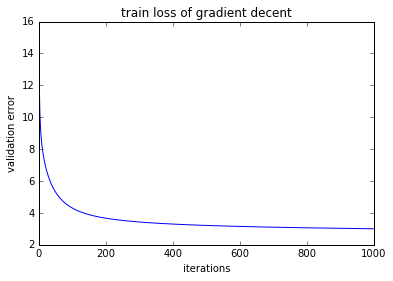

In [13]:
Q0 = Q
P0 = P
N0 = 1000
loss0 = []
t_iter0 = 0
for i in range(N0):
    Q0,P0,t = GradientDecent(train,Q0,P0)
    loss0.append(Error(validation,Q0,P0))
    t_iter0 += t
plt.plot(loss0)
plt.ylabel('validation error')
plt.xlabel('iterations')
plt.title('train loss of gradient decent')
print 'time per iteration is: ', t_iter0/N0, ', prediction error is: ', Error(test,Q0,P0)

$TrainWithSGD :$

time per iteration is:  2.8521818924e-05 , prediction error is:  1.45804732537


/home/yuanze/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/yuanze/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/yuanze/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/yuanze/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


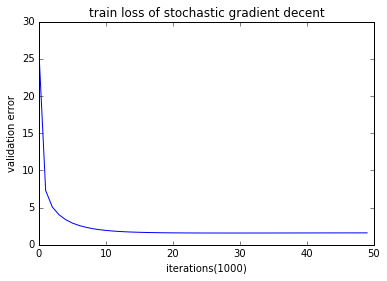

In [17]:
Q1 = Q
P1 = P
N1 = 10000000
loss1 = []
t_iter1 = 0
for i in range(N1):
    Q1,P1,t1 = StochasticGradientDecent(train,Q1,P1)
    if i%200000 == 0:
        loss1.append(Error(validation,Q1,P1))
    t_iter1 += t1
plt.plot(loss1)
plt.ylabel('validation error')
plt.xlabel('iterations(1000)')
plt.title('train loss of stochastic gradient decent')
print 'time per iteration is: ', t_iter1/N1, ', prediction error is: ', Error(test,Q1,P1)

$TrainWithMiniBatch :$

time per iteration is:  0.00570372793388 , prediction error is:  1.58044742135


/home/yuanze/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/yuanze/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/yuanze/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/yuanze/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


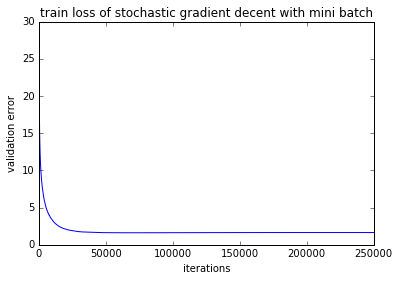

In [20]:
Q2 = Q
P2 = P
N2 = 250000
loss2 = []
t_iter2 = 0
for i in range(N2):
    Q2,P2,t2 = SGDwithBatch(train,Q2,P2)
    if i%5000:
        loss2.append(Error(validation,Q2,P2))
    t_iter2 += t2
plt.plot(loss2)
plt.ylabel('validation error')
plt.xlabel('iterations')
plt.title('train loss of stochastic gradient decent with mini batch')
print 'time per iteration is: ', t_iter2/N2, ', prediction error is: ', Error(test,Q2,P2)